In [14]:
# By: Adam Gregg

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
import seaborn as sns

from IPython.display import Image

%matplotlib inline

### Extracting historical data for Apple (AAPL) [2015 - 2016] and calculating daily returns

In [15]:
# Getting the data
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
from datetime import datetime

In [16]:
returns = data.DataReader('WIKI/AAPL', 'quandl', start = '2015-1-1', 
                          end = '2016-12-31')['AdjClose'].pct_change()

print(len(returns))

504


### Removing NaN values from the dataset

In [17]:
returns = returns.dropna()*100
returns

Date
2016-12-29    0.785702
2016-12-28    0.025700
2016-12-27    0.428229
2016-12-23   -0.631076
2016-12-22   -0.197391
2016-12-21    0.662138
2016-12-20   -0.093969
2016-12-19   -0.265071
2016-12-16   -0.574417
2016-12-15   -0.129344
2016-12-14   -0.543948
2016-12-13    0.000000
2016-12-12   -1.640767
2016-12-09    0.573698
2016-12-08   -1.605968
2016-12-07   -0.972173
2016-12-06   -0.972710
2016-12-05   -0.763984
2016-12-02    0.724040
2016-12-01   -0.373066
2016-11-30    0.940725
2016-11-29    0.850525
2016-11-28    0.098690
2016-11-25    0.197186
2016-11-23   -0.500939
2016-11-22    0.512452
2016-11-21   -0.062612
2016-11-18   -1.494675
2016-11-17   -0.099945
2016-11-16    0.036380
                ...   
2015-02-13   -0.586717
2015-02-12   -0.487882
2015-02-11   -1.249407
2015-02-10   -2.290199
2015-02-09   -1.884937
2015-02-06   -0.659873
2015-02-05    0.849239
2015-02-04   -0.705921
2015-02-03   -0.761124
2015-02-02   -0.016856
2015-01-30   -1.239147
2015-01-29    1.485149
2015-0

### Plots of the daily returns

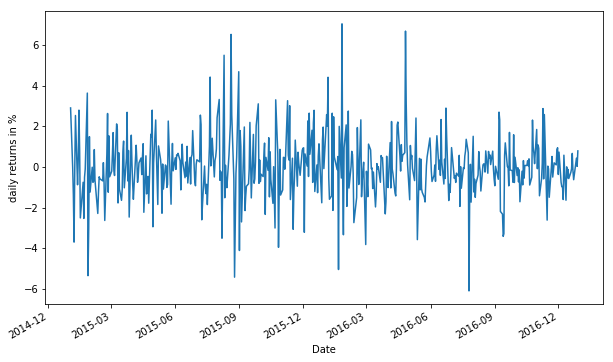

In [18]:
returns.plot(figsize = (10, 6))
plt.ylabel('daily returns in %');

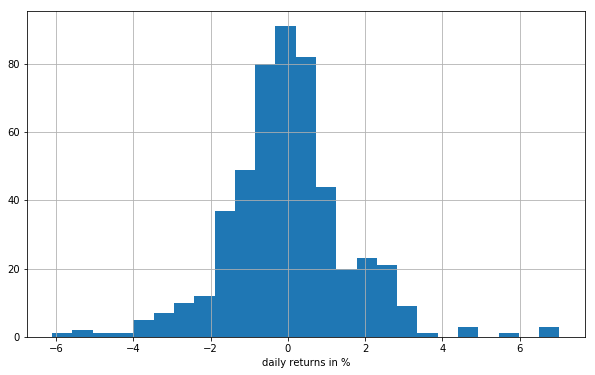

In [19]:
returns.hist(figsize = (10, 6), bins = 25)
plt.xlabel('daily returns in %');

### Calculating the mean and standard deviation of the daily returns

In [291]:
print('mean: %5.3f' % (returns.mean()))
print('Standard Deviation: % 5.3f' % (returns.std()))

mean: -0.007
Standard Deviation:  1.584


Building a model that assumes the daily returns follow a normal distribution. The normal distibution will be used for the likelihood computation with the Mean $\mu$ and Standard Deviation $\sigma$ as the parameters of the prior distributions.

In [199]:
with pm.Model() as model1:
    mu = pm.Uniform('mu', lower = -6.5, upper = 7.5, testval = returns.mean())
    sd = pm.HalfNormal('sigma', sd = 1, testval = returns.std())
    likelihood1 = pm.Normal('likelihood1', mu = mu, sd = sd, observed = returns.values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace1 = pm.sample(200000, step, start = start, progressbar = True)

logp = -948.68, ||grad|| = 3.5088: 100%|████████| 6/6 [00:00<00:00, 857.56it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 401000/401000 [04:12<00:00, 1586.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


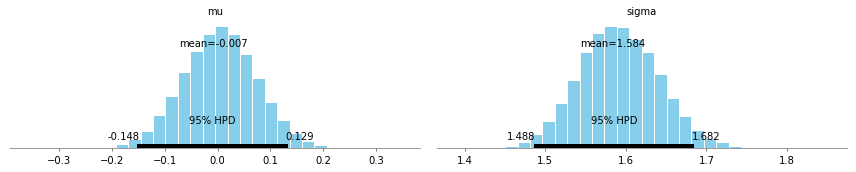

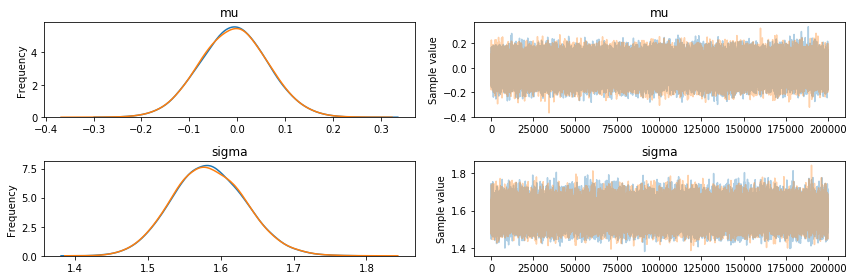

In [200]:
# Presenting the posterior distribution graphically
_= pm.plot_posterior(trace1)
_= pm.traceplot(trace1, varnames = ['mu', 'sigma'])

In [201]:
# Posterior Predictive Check
ppc1 = pm.sample_ppc(trace1, samples = 500, model = model1)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1039.30it/s]


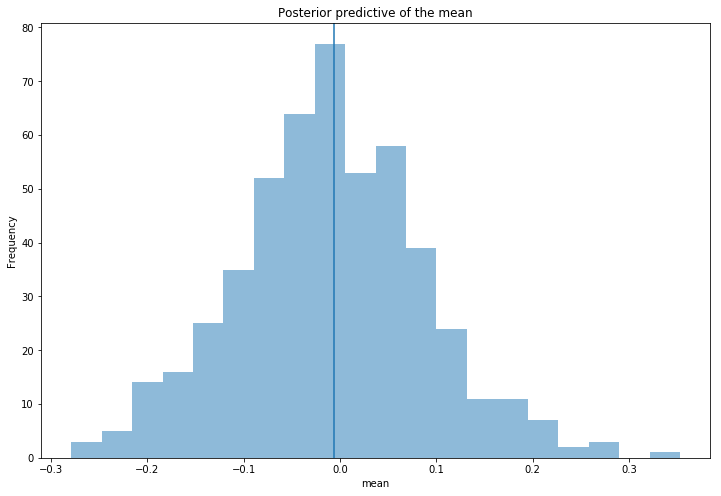

In [292]:
_, ax = plt.subplots(figsize=(12, 8))
ax.hist([likelihood1.mean() for likelihood1 in ppc1['likelihood1']], bins = 20, alpha = 0.5)
ax.axvline(returns.mean())
ax.set(title = 'Posterior predictive of the mean', xlabel = 'mean', ylabel = 'Frequency');

Building a model that assumes the daily returns follow a T-Student distribution. The T-Student distibution will be used for the likelihood computation with the Mean $\mu$, Standard Deviation $\sigma$, and degrees of freedom nu as the parameters of the prior distributions.

In [204]:
with pm.Model() as model2:
    mu = pm.Uniform('mu', lower = -6.5, upper = 7.5, testval = returns.mean())
    sd = pm.HalfNormal('sigma', sd = 1, testval = returns.std())
    nu = pm.Exponential('nu', .1)
    likelihood2 = pm.StudentT('likelihood2', mu = mu, sd = sd, nu = nu, observed = returns.values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace2 = pm.sample(200000, step, start = start, progressbar = True)

logp = -923.51, ||grad|| = 5.5178: 100%|██████| 17/17 [00:00<00:00, 766.65it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 401000/401000 [05:17<00:00, 1262.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


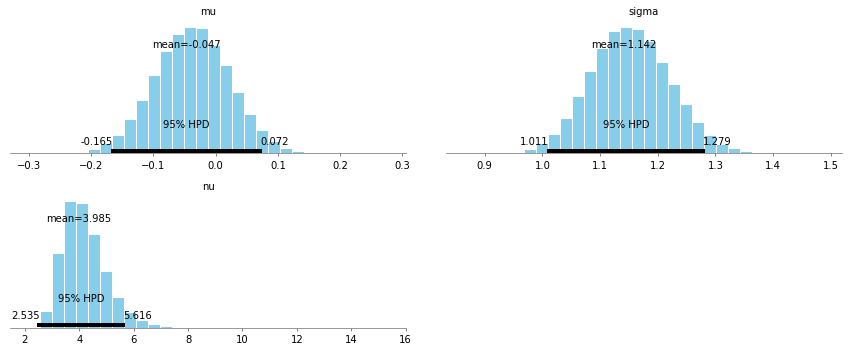

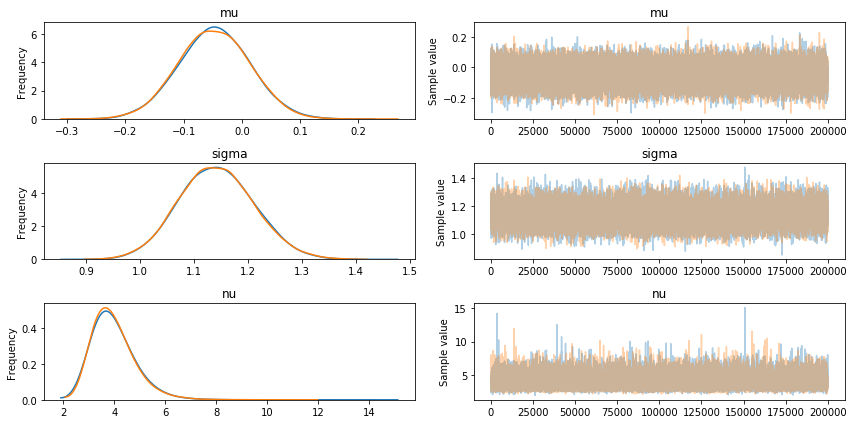

In [222]:
# Presenting the posterior distribution graphically
_= pm.plot_posterior(trace2)
_= pm.traceplot(trace2, varnames = ['mu', 'sigma', 'nu'])

In [216]:
# Posterior Predictive Check
ppc2 = pm.sample_ppc(trace2, samples = 500, model = model2)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1064.08it/s]


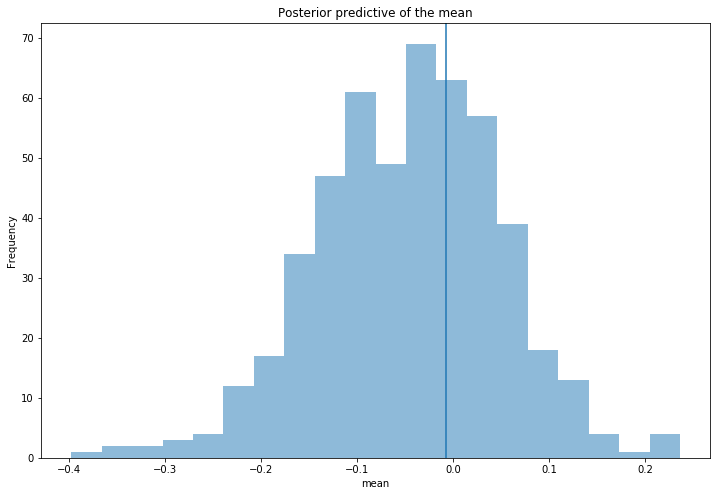

In [293]:
_, ax = plt.subplots(figsize = (12, 8))
ax.hist([likelihood2.mean() for likelihood2 in ppc2['likelihood2']], bins = 20, alpha = 0.5)
ax.axvline(returns.mean())
ax.set(title = 'Posterior predictive of the mean', xlabel = 'mean', ylabel = 'Frequency');

# Summary & Conclusion

### Parameters of interest in both models

In the Normal distribution, the parameters of interest were the mean (mu), and the standard deviation (sigma).
In the T-student distribution, the parameters of interest were the mean (mu), the standard deviation (sigma), and the degrees of freedom (nu).

### Good priors for the identified parameters

In the Normal distribution, good priors are the uniform distribution for the mean, and the halfnormal distribution for the standard deviation.

In the T-student distribution, good priors are the uniform distribution for the mean, the halfnormal distribution for the standard deviation, and the exponential distribution for the degrees of freedom.

### Comparison of the two models

Both models produce good results, however the Normal distribution model is slightly more accurate when reproducing patterns in the real data as seen in Posterior Predictive Check where we examine how close the inferred means are to the actual sample mean. Also, when analyzing the posterior plots, we can see that the Normal distribution produced more precise values for mu and sigma than the T-student distribution when compared to the actual values for mean and standard deviation of the data set.

### HDI estimate

HDI estimate for the Normal distribution: mu (-0.148, 0.129), sigma (1.488, 1.682).
HDI estimate for the T-student distribution: mu (-0.165, 0.072), sigma (1.011, 1.279), nu (2.535, 5.616).

### Future improvements in the models

The T-student model can be improved by possibly using a different prior distribution in order to estimate the degrees of freedom since the trace plot has the most convergence issues and has a high measure of uncertainty. 

### Sample size

In both models, a sample size of 200,000 was used which was sufficient in producing accurate results.